In [1]:
import numpy as np
import os
from torch import nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from data_preparation import DataExtractor
from utils import visualize
from nn_training import set_random_seed, train

run_config = {
    'hidden_sizes': [100, 50, 50],
    'lr': 3e-5,
    'weight_decay': 0,
    'batch_size': 128
}

set_random_seed(57)

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 16

In [2]:
data_dir = '../Data/'

extractor = DataExtractor()

for base_element in ('Ti', 'Zr'):
    files_dir = os.path.join(data_dir, base_element)
    for file in os.listdir(files_dir):
        if file.endswith('.dat'):
            extractor.read_file(files_dir, file, 2, base_element)
        elif file.endswith('.unalloyed'):
            extractor.read_file(files_dir, file, 1, base_element)
files_dir = os.path.join(data_dir, 'Ternary')
for file in os.listdir(files_dir):
    if file.endswith('.dat'):
        extractor.read_file(files_dir, file, num_elements=3, base_element='Ti')

data = extractor.dataframe

In [3]:
def train_mlp(features_train, features_test, target_train, target_test):
    scaler = StandardScaler().fit(features_train)
    scaled_features_train = scaler.transform(features_train)
    scaled_features_test = scaler.transform(features_test)
    target_scaler = StandardScaler().fit(target_train.reshape(-1, 1))
    scaled_target_train = target_scaler.transform(target_train.reshape(-1, 1))
    scaled_target_test = target_scaler.transform(target_test.reshape(-1, 1))

    train_dataset = TensorDataset(torch.Tensor(scaled_features_train), torch.Tensor(scaled_target_train))
    test_dataset = TensorDataset(torch.Tensor(scaled_features_test), torch.Tensor(scaled_target_test))
    train_loader = DataLoader(train_dataset, batch_size=run_config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=run_config['batch_size'], shuffle=False)

    model = nn.Sequential(nn.Linear(5, run_config['hidden_sizes'][0]),
                          nn.BatchNorm1d(run_config['hidden_sizes'][0]),
                          nn.ReLU(),
                          nn.Linear(run_config['hidden_sizes'][0], run_config['hidden_sizes'][1]),
                          nn.BatchNorm1d(run_config['hidden_sizes'][1]),
                          nn.ReLU(),
                          nn.Linear(run_config['hidden_sizes'][1], run_config['hidden_sizes'][2]),
                          nn.BatchNorm1d(run_config['hidden_sizes'][2]),
                          nn.ReLU(),
                          nn.Linear(run_config['hidden_sizes'][2], 1))

    optimizer = torch.optim.Adam(model.parameters(), lr=run_config['lr'], weight_decay=run_config['weight_decay'])
    loss = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=300, verbose=False)
    res_train, res_test = train(model, train_loader, test_loader, test_loader, loss, optimizer, "cpu",
                                n_epochs=2000, scheduler=scheduler, verbose=False,
                                check_dir=None, save_every=5,
                                model_name='nn_a', show_tqdm=False)
    return target_scaler.inverse_transform(np.array(res_train)), target_scaler.inverse_transform(np.array(res_test))

In [4]:

features = data[data.el1 == 'Ti'].apply(extractor.extract_properties, axis=1, result_type='expand').to_numpy()
target = data[data.el1 == 'Ti']['a'].to_numpy()

cv_mse_train = []
cv_mse_test = []
cv_r2_train = []
cv_r2_test = []

for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=57).split(features):
    features_train, features_test = features[train_index], features[test_index]
    target_train, target_test = target[train_index], target[test_index]
    res_train, res_test = train_mlp(features_train, features_test, target_train, target_test)

    cv_mse_train.append(mean_squared_error(target_train, res_train, squared=False))
    cv_mse_test.append(mean_squared_error(target_test, res_test, squared=False))
    cv_r2_train.append(r2_score(target_train, res_train))
    cv_r2_test.append(r2_score(target_test, res_test))
visualize(target_test, res_test, 'Параметр решетки MLP (Титановые сплавы)', 2.9, 3.7)
print(f"A RMSE Train: {np.mean(cv_mse_train):.3f}±{np.std(cv_mse_train):.3f}\n"
      f"A RMSE Test:  {np.mean(cv_mse_test):.3f}±{np.std(cv_mse_test):.3f}")
print(f"A R^2 Train: {np.mean(cv_r2_train):.3f}±{np.std(cv_r2_train):.3f}\n"
      f"A R^2 Test:  {np.mean(cv_r2_test):.3f}±{np.std(cv_r2_test):.3f}")

In [5]:
features = data[data.el1 == 'Zr'].apply(extractor.extract_properties, axis=1, result_type='expand').to_numpy()
target = data[data.el1 == 'Zr']['a'].to_numpy()

cv_mse_train = []
cv_mse_test = []
cv_r2_train = []
cv_r2_test = []

for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=57).split(features):
    features_train, features_test = features[train_index], features[test_index]
    target_train, target_test = target[train_index], target[test_index]
    res_train, res_test = train_mlp(features_train, features_test, target_train, target_test)

    cv_mse_train.append(mean_squared_error(target_train, res_train, squared=False))
    cv_mse_test.append(mean_squared_error(target_test, res_test, squared=False))
    cv_r2_train.append(r2_score(target_train, res_train))
    cv_r2_test.append(r2_score(target_test, res_test))
visualize(target_test, res_test, 'Параметр решетки MLP (Циркониевые сплавы)', 2.9, 3.7)
print(f"A RMSE Train: {np.mean(cv_mse_train):.3f}±{np.std(cv_mse_train):.3f}\n"
      f"A RMSE Test:  {np.mean(cv_mse_test):.3f}±{np.std(cv_mse_test):.3f}")
print(f"A R^2 Train: {np.mean(cv_r2_train):.3f}±{np.std(cv_r2_train):.3f}\n"
      f"A R^2 Test:  {np.mean(cv_r2_test):.3f}±{np.std(cv_r2_test):.3f}")

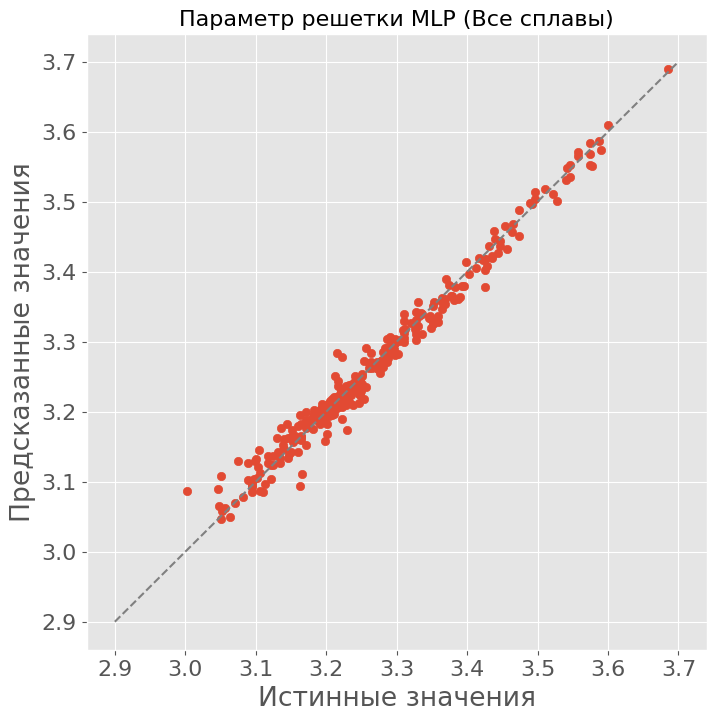

A RMSE Train: 0.195±0.002
A RMSE Test:  0.019±0.001
A R^2 Train: -0.996±0.020
A R^2 Test:  0.981±0.002


In [6]:
features = data.apply(extractor.extract_properties, axis=1, result_type='expand').to_numpy()
target = data['a'].to_numpy()

cv_mse_train = []
cv_mse_test = []
cv_r2_train = []
cv_r2_test = []

for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=57).split(features):
    features_train, features_test = features[train_index], features[test_index]
    target_train, target_test = target[train_index], target[test_index]
    res_train, res_test = train_mlp(features_train, features_test, target_train, target_test)

    cv_mse_train.append(mean_squared_error(target_train, res_train, squared=False))
    cv_mse_test.append(mean_squared_error(target_test, res_test, squared=False))
    cv_r2_train.append(r2_score(target_train, res_train))
    cv_r2_test.append(r2_score(target_test, res_test))
visualize(target_test, res_test, 'Параметр решетки MLP (Все сплавы)', 2.9, 3.7)
print(f"A RMSE Train: {np.mean(cv_mse_train):.3f}±{np.std(cv_mse_train):.3f}\n"
      f"A RMSE Test:  {np.mean(cv_mse_test):.3f}±{np.std(cv_mse_test):.3f}")
print(f"A R^2 Train: {np.mean(cv_r2_train):.3f}±{np.std(cv_r2_train):.3f}\n"
      f"A R^2 Test:  {np.mean(cv_r2_test):.3f}±{np.std(cv_r2_test):.3f}")

In [7]:
features = data[data.el1 == 'Ti'].apply(extractor.extract_properties, axis=1, result_type='expand').to_numpy()
target = data[data.el1 == 'Ti']['e'].to_numpy()

cv_mse_train = []
cv_mse_test = []
cv_r2_train = []
cv_r2_test = []

for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=57).split(features):
    features_train, features_test = features[train_index], features[test_index]
    target_train, target_test = target[train_index], target[test_index]
    res_train, res_test = train_mlp(features_train, features_test, target_train, target_test)

    cv_mse_train.append(mean_squared_error(target_train, res_train, squared=False))
    cv_mse_test.append(mean_squared_error(target_test, res_test, squared=False))
    cv_r2_train.append(r2_score(target_train, res_train))
    cv_r2_test.append(r2_score(target_test, res_test))

visualize(target_test, res_test, 'Модуль Юнга MLP (Титановые сплавы)', -10, 275)
print(f"E RMSE Train: {np.mean(cv_mse_train):.3f}±{np.std(cv_mse_train):.3f}\n"
      f"E RMSE Test:  {np.mean(cv_mse_test):.3f}±{np.std(cv_mse_test):.3f}")
print(f"E R^2 Train: {np.mean(cv_r2_train):.3f}±{np.std(cv_r2_train):.3f}\n"
      f"E R^2 Test:  {np.mean(cv_r2_test):.3f}±{np.std(cv_r2_test):.3f}")

In [8]:
features = data[data.el1 == 'Zr'].apply(extractor.extract_properties, axis=1, result_type='expand').to_numpy()
target = data[data.el1 == 'Zr']['e'].to_numpy()

cv_mse_train = []
cv_mse_test = []
cv_r2_train = []
cv_r2_test = []

for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=57).split(features):
    features_train, features_test = features[train_index], features[test_index]
    target_train, target_test = target[train_index], target[test_index]
    res_train, res_test = train_mlp(features_train, features_test, target_train, target_test)

    cv_mse_train.append(mean_squared_error(target_train, res_train, squared=False))
    cv_mse_test.append(mean_squared_error(target_test, res_test, squared=False))
    cv_r2_train.append(r2_score(target_train, res_train))
    cv_r2_test.append(r2_score(target_test, res_test))

visualize(target_test, res_test, 'Модуль Юнга MLP (Циркониевые сплавы)', -10, 275)
print(f"E RMSE Train: {np.mean(cv_mse_train):.3f}±{np.std(cv_mse_train):.3f}\n"
      f"E RMSE Test:  {np.mean(cv_mse_test):.3f}±{np.std(cv_mse_test):.3f}")
print(f"E R^2 Train: {np.mean(cv_r2_train):.3f}±{np.std(cv_r2_train):.3f}\n"
      f"E R^2 Test:  {np.mean(cv_r2_test):.3f}±{np.std(cv_r2_test):.3f}")

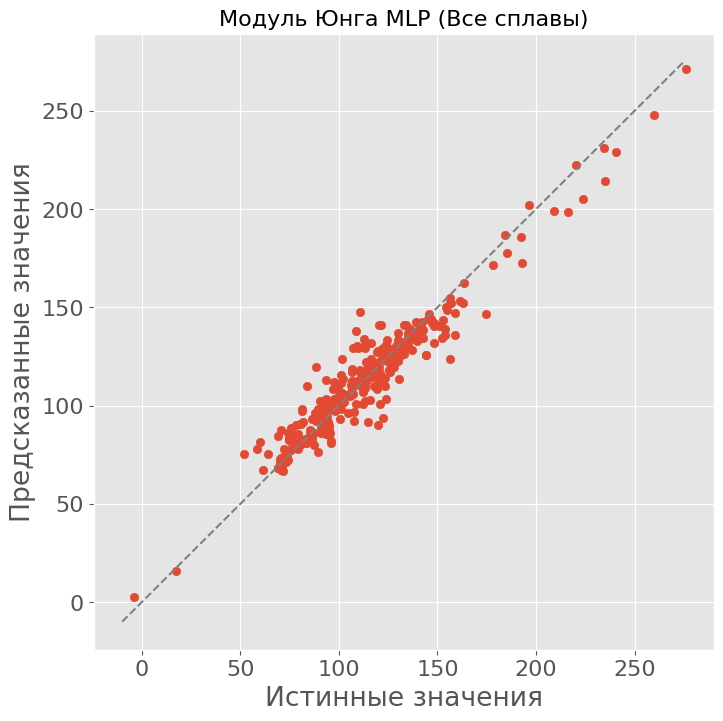

E RMSE Train: 46.719±1.726
E RMSE Test:  14.037±3.595
E R^2 Train: -0.889±0.059
E R^2 Test:  0.822±0.069


In [9]:
features = data.apply(extractor.extract_properties, axis=1, result_type='expand').to_numpy()
target = data['e'].to_numpy()

cv_mse_train = []
cv_mse_test = []
cv_r2_train = []
cv_r2_test = []

for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=57).split(features):
    features_train, features_test = features[train_index], features[test_index]
    target_train, target_test = target[train_index], target[test_index]
    res_train, res_test = train_mlp(features_train, features_test, target_train, target_test)

    cv_mse_train.append(mean_squared_error(target_train, res_train, squared=False))
    cv_mse_test.append(mean_squared_error(target_test, res_test, squared=False))
    cv_r2_train.append(r2_score(target_train, res_train))
    cv_r2_test.append(r2_score(target_test, res_test))

visualize(target_test, res_test, 'Модуль Юнга MLP (Все сплавы)', -10, 275)
print(f"E RMSE Train: {np.mean(cv_mse_train):.3f}±{np.std(cv_mse_train):.3f}\n"
      f"E RMSE Test:  {np.mean(cv_mse_test):.3f}±{np.std(cv_mse_test):.3f}")
print(f"E R^2 Train: {np.mean(cv_r2_train):.3f}±{np.std(cv_r2_train):.3f}\n"
      f"E R^2 Test:  {np.mean(cv_r2_test):.3f}±{np.std(cv_r2_test):.3f}")